### Notebook for clustering 6mpi cardiac leucocytes from scratch

#### Environment: Test (= like Scanpy + mmnpy (Bioconda))

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240320
- **Last modified**: 240320

##### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from scipy.sparse import csr_matrix

/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
%matplotlib inline

-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                 10.2.0
asttokens           NA
beta_ufunc          NA
binom_ufunc         NA
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
hypergeom_ufunc     NA
igraph              0.11.4
ipykernel           6.29.3
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.42.0
matplotlib          3.8.3
mpl_toolkits        NA
natsort             8.4.0
nbinom_ufunc        NA
numba               0.59.0
numpy               1.26.4
packaging           24.0
pandas              2.2.1
parso               0.8.3
patsy               0.5.6
pickleshare         0.7.5
platformdirs        4.2.0
prompt_toolkit      3.0.42
psutil              5.9.8


##### Load in demultiplexed & merged data set (Pkp2+Ttn)

In [3]:
adata = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Merge_demux_QCed_ac240220.raw.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 44594 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    layers: 'counts', 'sqrt_norm'

### Preprocessing

normalizing counts per cell


    finished (0:00:00)


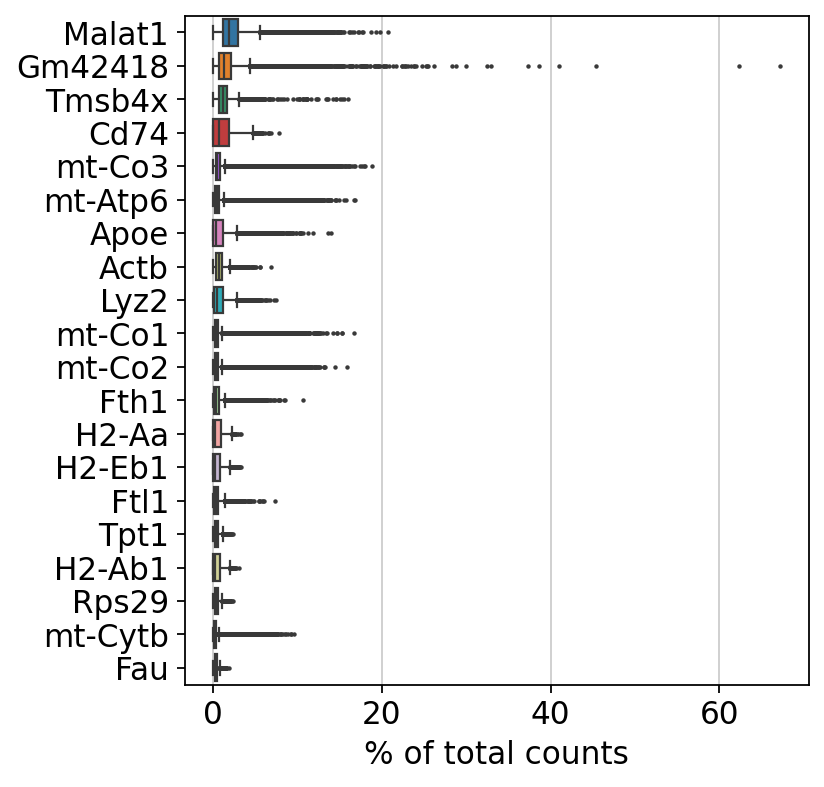

In [4]:
# show the genes that yield the highest fraction of counts across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

##### Basic filtering

In [5]:
sc.pp.filter_cells(adata, min_genes=200)

##### As QC was already performed I will directly continue with **normalization**

In [6]:
adata.layers['counts'] = adata.X.copy()

counts = adata.layers['counts']
counts_sparse = csr_matrix(counts)
counts_df = pd.DataFrame.sparse.from_spmatrix(counts_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", counts_df.shape)
print(counts_df)



Shape of counts DataFrame: (44594, 32285)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACCCAAGAAGCGAA-1-A1     0       0        0        0    0      0        0   
AAACCCAAGATACAGT-1-A1     0       0        0        0    0      0        0   
AAACCCAAGTCTAACC-1-A1     0       0        0        0    0      0        0   
AAACCCACAACCACGC-1-A1     0       0        0        0    0      0        0   
AAACCCAGTGCTCTCT-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGTTGCAAGCTCTA-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTACAGGTG-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTAGTAAGT-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCCAGGAC-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCGGGACT-1-B2     0       0        0        0    0      0        0   

                     

In [7]:
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell and square-root-normalize the data to be able to compare the counts among cells
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, target_sum=1e4, inplace = False)["X"])

sqrt_norm_data = adata.layers['sqrt_norm']
sqrt_norm_sparse = csr_matrix(sqrt_norm_data)
sqrt_norm_df = pd.DataFrame.sparse.from_spmatrix(sqrt_norm_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", sqrt_norm_df.shape)
print(sqrt_norm_df)

normalizing counts per cell


    finished (0:00:00)
Shape of counts DataFrame: (44594, 32285)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACCCAAGAAGCGAA-1-A1     0       0        0        0    0      0        0   
AAACCCAAGATACAGT-1-A1     0       0        0        0    0      0        0   
AAACCCAAGTCTAACC-1-A1     0       0        0        0    0      0        0   
AAACCCACAACCACGC-1-A1     0       0        0        0    0      0        0   
AAACCCAGTGCTCTCT-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGTTGCAAGCTCTA-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTACAGGTG-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTAGTAAGT-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCCAGGAC-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCGGGACT-1-B2     0       0        0        0    0      0        0   

In [8]:
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell and logarthmize the data to be able to compare the counts among cells
adata.layers["log_norm"] = sc.pp.log1p(sc.pp.normalize_total(adata, target_sum=1e4, inplace = False)["X"])

log_norm_data = adata.layers['log_norm']
log_norm_sparse = csr_matrix(log_norm_data)
log_norm_df = pd.DataFrame.sparse.from_spmatrix(log_norm_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", log_norm_df.shape)
print(log_norm_df)

normalizing counts per cell


    finished (0:00:00)
Shape of counts DataFrame: (44594, 32285)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACCCAAGAAGCGAA-1-A1     0       0        0        0    0      0        0   
AAACCCAAGATACAGT-1-A1     0       0        0        0    0      0        0   
AAACCCAAGTCTAACC-1-A1     0       0        0        0    0      0        0   
AAACCCACAACCACGC-1-A1     0       0        0        0    0      0        0   
AAACCCAGTGCTCTCT-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGTTGCAAGCTCTA-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTACAGGTG-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTAGTAAGT-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCCAGGAC-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCGGGACT-1-B2     0       0        0        0    0      0        0   

In [9]:
#Now I have an AnnData object with three layers
adata

AnnData object with n_obs × n_vars = 44594 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    layers: 'counts', 'sqrt_norm', 'log_norm'

##### Identify Highly variable genes

extracting highly variable genes


/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be ch

    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:508: FutureWarning: The provided callable <function nanmean at 0x7ff9f0236cb0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby("gene").agg(
/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:508: FutureWarning: The provided callable <function nanmean at 0x7ff9f0236cb0> is currently 

Highly variable genes intersection: 571
Number of batches where gene is variable:
highly_variable_nbatches
0     18785
1      2105
2      1339
3      1163
4      1068
5       900
6       781
7       665
30      571
8       565
9       492
10      433
11      375
13      295
12      291
14      225
15      218
17      200
29      181
16      166
18      164
28      145
21      144
20      141
19      138
22      131
27      131
24      122
23      120
26      117
25      114
Name: count, dtype: int64


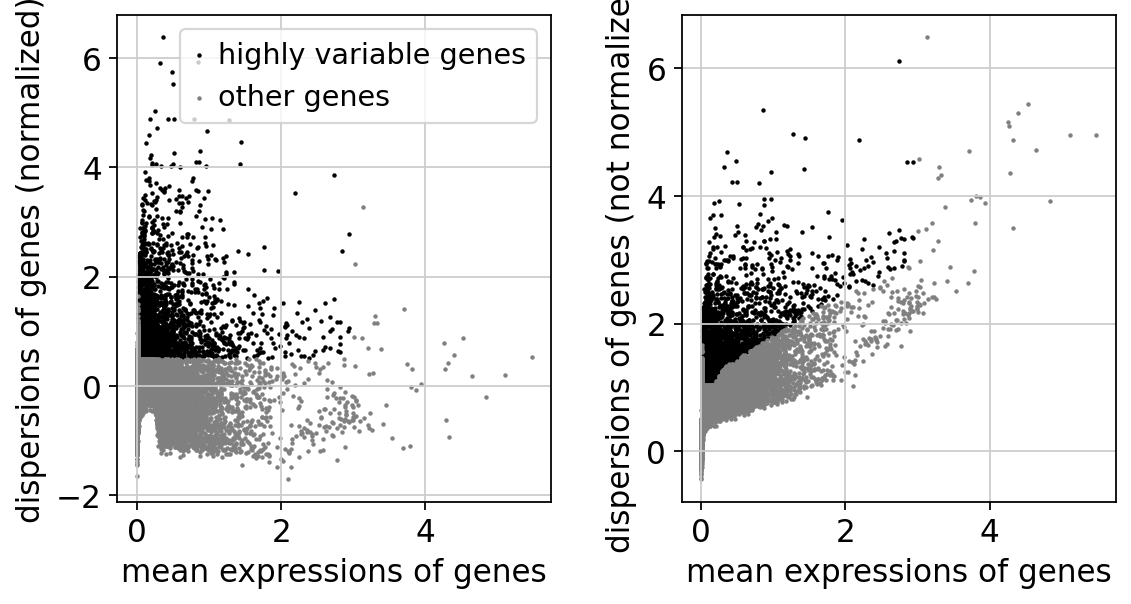

AnnData object with n_obs × n_vars = 44594 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', '

In [10]:
#Select HVGs from every batch seperately to get only cell type variation

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, layer = 'log_norm', batch_key = 'sample')

print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))             #HVGs that are detected in all batches
print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata.var.highly_variable_nbatches > 0
sc.pl.highly_variable_genes(adata)
adata

In [11]:
var_select = adata.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
len(var_genes)

11395

### Data integration

First each library needs to be stored in an individual AnnData object

In [12]:
adata.obs["library"].cat.categories

Index(['A1', 'A2', 'A3', 'A4', 'B1', 'B2'], dtype='object')

In [13]:
# split per batch into new objects
batches = ['A1','A2','A3', 'A4', 'B1', 'B2']
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['library'] == batch,]

alldata   

{'A1': View of AnnData object with n_obs × n_vars = 6884 × 32285
     obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
     var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2', 'highly_variable', 'means', 'dispersions', 'disp

Perform Batch correction with MNN

In [14]:
adata_corrected = sc.external.pp.mnn_correct(alldata['A1'],alldata['A2'],alldata['A3'], alldata['A4'],alldata['B1'],alldata['B2'], 
                                             svd_dim = 50, 
                                             batch_key = 'lib_prep', 
                                             batch_categories = ['A1','A2','A3', 'A4', 'B1', 'B2'],
                                             save_raw = True,                                                               #Non-Batch-corrected matrix will be stored in raw
                                             var_subset = var_genes)

/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/utils.py:30: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  dist[i, j] = np.dot(m[i], n[j])
/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/utils.py:205: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'C', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  scale = np.dot(working, grad)
/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/utils.py:215: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'C', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  curproj = np.dot(grad, curcell)


Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 5: processing batch 1
  Looking for MNNs...


/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/utils.py:90: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/utils.py (96)

File "../../../miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/utils.py", line 96:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8), forceobj=True)


  Computing correction vectors...


/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/utils.py:105: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "compute_correction" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/utils.py (110)

File "../../../miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/utils.py", line 110:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  @jit(float32[:, :](float32[:, :], float32[:, :], int32[:], int32[:], float32[:, :], float32), forceobj=True)


  Removing components...
  Adjusting variance...
  Applying correction...
Step 2 of 5: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 3 of 5: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 4 of 5: processing batch 4
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 5 of 5: processing batch 5
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...


/home/acirnu/miniforge3/envs/Test/lib/python3.10/site-packages/mnnpy/mnn.py:129: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = AnnData.concatenate(*datas, batch_key=batch_key,


Done.


The mnn_correct function returns a tuple with the AnnData object, list of cell pairs and of angles.Hence, adata_corrected[0] is the new AnnData object.

We get corrected expression values for all genes even though only the selected genes were used for finding neighbor cells. 

For later analysis we want to do dimensionality reduction etc. on the variable genes only, so we will subset the data to only include the variable genes.

In [15]:
adata_corrected = adata_corrected[0][:,var_genes]
adata_corrected.X.shape

(44594, 11395)

In [16]:
adata_corrected.write('/home/acirnu/data/ACM_cardiac_leuco/Test_ac240321.raw.h5ad')  

##### Freeze the state of the AnnData object (normalized + logarithmized) in `.raw` for later use in differential testing and gene expression visualizations

In [ ]:
#Store the normalized and logarithmized data in .raw
adata.raw = adata

##### Filter for HVGs

In [ ]:
adata = adata[:, adata.var.highly_variable]
adata

#### Regress out effects of total counts per cell and scale the data to unit variance

In [ ]:
sc.pp.regress_out(adata, ["total_counts"])

### Principal Component Analysis

In [ ]:
# Reduce dimensionality of the data by using PCA, which reveals the main axes of variation
sc.tl.pca(adata, svd_solver="arpack")

In [ ]:
#Scatter plot in the PCA coordinates (not used later on)
sc.pl.pca(adata, color="Trem2")                              #Cst3 is a gene

In [ ]:
# Find out how many PCs contribute to most of the variance in the data in order to properly compute the neighborhood relations of cells later on
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata

### Computing and Embedding the neighborhood graph

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.paga(adata, groups='condition')
sc.pl.paga(adata, plot=False)           # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=["Cd8a", "Trem2", "S100a9"])

### Clustering the neighborhood graph

In [ ]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

In [ ]:
sc.pl.umap(adata, color=["leiden", "Cd8a", "Trem2"])

### Finding marker genes

In [ ]:
sc.settings.verbosity = 2

In [ ]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
#Show the top 10 ranked genes per cluster
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)

In [ ]:
#Get a table with the scores and groups
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

In [ ]:
#Compare to a single cluster
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

In [ ]:
#More detailed view
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

In [ ]:
#Compare a gene across clusters
sc.pl.violin(adata, ["Trem2"], groupby="leiden")